APARTADO 3: LIMPIEZA DE LOS DATOS
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset cargado: 300 películas con 30 variables
Dimensiones iniciales: (300, 30)

3.1. GESTIÓN DE DATOS PERDIDOS
----------------------------------------
                      Variable  Valores_perdidos  Porcentaje
              estreno_millones                56   18.666667
        multiplicador_taquilla                56   18.666667
               exito_comercial                43   14.333333
                           roi                43   14.333333
          presupuesto_millones                38   12.666667
          porcentaje_domestico                30   10.000000
recaudacion_domestica_millones                30   10.000000
  recaudacion_mundial_millones                23    7.666667
               imdb_puntuacion                 1    0.333333
                    imdb_votos                 1    0.333333
           p

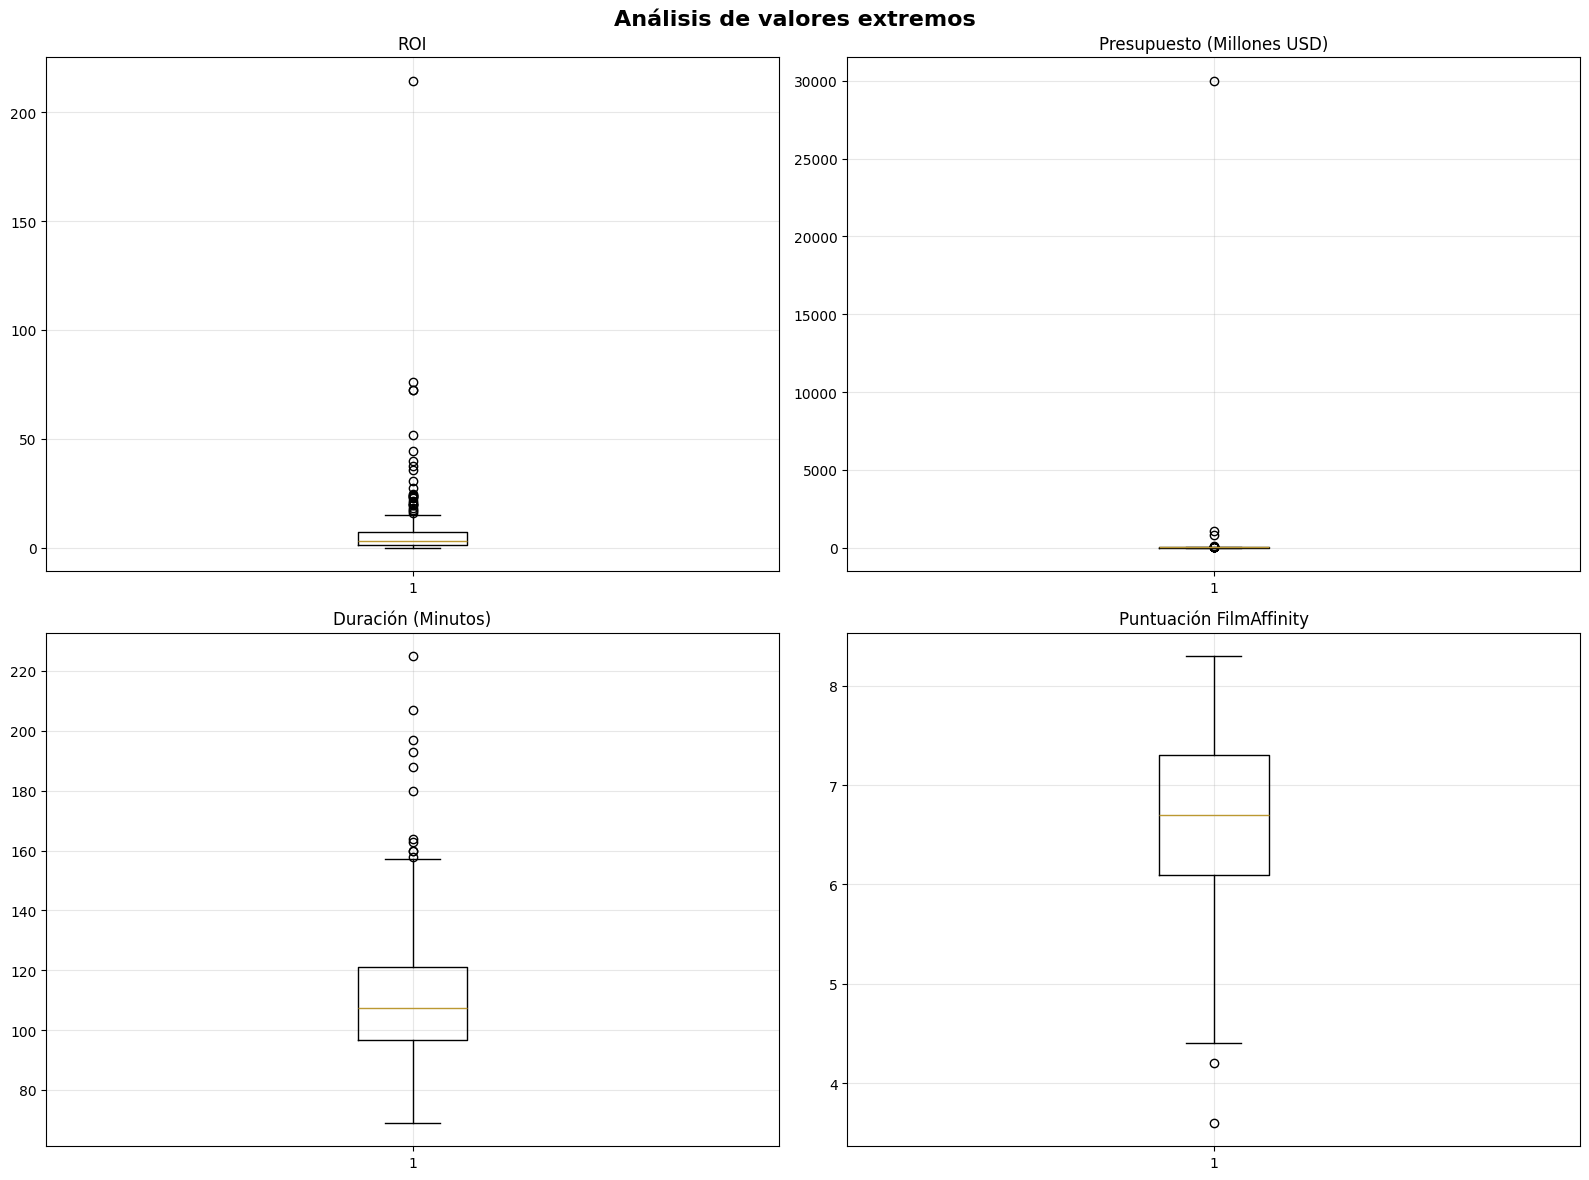


Dimensiones finales: (300, 30)
Valores perdidos restantes: 2


In [3]:
# ============================================================================
# APARTADO 3: LIMPIEZA DE LOS DATOS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("="*70)
print("APARTADO 3: LIMPIEZA DE LOS DATOS")
print("="*70)

# ============================================================================
# CARGA DEL DATASET
# ============================================================================

from google.colab import drive
drive.mount("/content/drive")

df = pd.read_csv("/content/drive/MyDrive/Tipología/PR2/datasets/paso02b-peliculas_filmaffinity_1980-1989_imdb_derivadas.csv",
                 sep=';', encoding='utf-8')

print(f"Dataset cargado: {len(df)} películas con {len(df.columns)} variables")
print(f"Dimensiones iniciales: {df.shape}")

# ============================================================================
# 3.1. GESTIÓN DE DATOS PERDIDOS
# ============================================================================

print("\n3.1. GESTIÓN DE DATOS PERDIDOS")
print("-" * 40)

# Análisis inicial
missing_data = pd.DataFrame({
    'Variable': df.columns,
    'Valores_perdidos': df.isnull().sum(),
    'Porcentaje': (df.isnull().sum() / len(df)) * 100
})
missing_data = missing_data[missing_data['Valores_perdidos'] > 0].sort_values('Porcentaje', ascending=False)
print(missing_data.to_string(index=False))

# Identificar valores cero problemáticos
if 'recaudacion_mundial_millones' in df.columns:
    ceros_recaudacion = (df['recaudacion_mundial_millones'] == 0).sum()
    print(f"\nValores cero en recaudacion_mundial_millones: {ceros_recaudacion}")

df_clean = df.copy()

# Tratar ceros como valores perdidos
if 'recaudacion_mundial_millones' in df_clean.columns:
    df_clean.loc[df_clean['recaudacion_mundial_millones'] == 0, 'recaudacion_mundial_millones'] = np.nan

# Imputación variables financieras por mediana según género
variables_financieras = ['presupuesto_millones', 'recaudacion_domestica_millones',
                        'recaudacion_mundial_millones', 'estreno_millones']

for var in variables_financieras:
    if var in df_clean.columns and df_clean[var].isnull().sum() > 0:
        for genero in df_clean['genero_principal'].unique():
            if pd.notna(genero):
                mask_genero = (df_clean['genero_principal'] == genero)
                valores_genero = df_clean.loc[mask_genero, var].dropna()

                if len(valores_genero) > 0:
                    mediana = valores_genero.median()
                    df_clean.loc[mask_genero & df_clean[var].isnull(), var] = mediana

        # Mediana global para casos restantes
        mediana_global = df_clean[var].median()
        df_clean[var].fillna(mediana_global, inplace=True)

# Imputación variables IMDB con kNN
variables_imdb = ['puntuacion_imdb_num', 'diferencia_puntuaciones', 'puntuacion_promedio']
variables_existentes = [var for var in variables_imdb if var in df_clean.columns and df_clean[var].isnull().sum() > 0]

if variables_existentes:
    features_for_knn = ['puntuacion', 'duracion_minutos', 'anio'] + variables_existentes
    features_disponibles = [var for var in features_for_knn if var in df_clean.columns]

    if len(features_disponibles) >= 4:
        imputer = KNNImputer(n_neighbors=5)
        df_temp = df_clean[features_disponibles].copy()
        df_imputed = pd.DataFrame(
            imputer.fit_transform(df_temp),
            columns=features_disponibles,
            index=df_temp.index
        )

        for var in variables_existentes:
            df_clean.loc[:, var] = df_imputed[var]

# Recálculo de variables derivadas
if all(var in df_clean.columns for var in ['presupuesto_millones', 'recaudacion_mundial_millones']):
    df_clean['roi'] = df_clean['recaudacion_mundial_millones'] / df_clean['presupuesto_millones']

if 'roi' in df_clean.columns:
    df_clean['exito_comercial'] = (df_clean['roi'] > 2.0).astype(int)

if all(var in df_clean.columns for var in ['recaudacion_domestica_millones', 'recaudacion_mundial_millones']):
    df_clean['porcentaje_domestico'] = (df_clean['recaudacion_domestica_millones'] / df_clean['recaudacion_mundial_millones']) * 100

if all(var in df_clean.columns for var in ['recaudacion_mundial_millones', 'estreno_millones']):
    df_clean['multiplicador_taquilla'] = df_clean['recaudacion_mundial_millones'] / df_clean['estreno_millones']

print("Imputación completada")

# ============================================================================
# 3.2. GESTIÓN DE TIPOS DE DATOS
# ============================================================================

print("\n3.2. GESTIÓN DE TIPOS DE DATOS")
print("-" * 40)

# Variables categóricas
variables_categoricas = ['genero_principal', 'pais', 'direccion']
for var in variables_categoricas:
    if var in df_clean.columns:
        df_clean[var] = df_clean[var].astype('category')

# Variables binarias
variables_binarias = ['exito_comercial', 'es_usa']
for var in variables_binarias:
    if var in df_clean.columns:
        df_clean[var] = df_clean[var].astype('int8')

# Variables numéricas
variables_numericas = ['puntuacion', 'puntuacion_imdb_num', 'duracion_minutos',
                      'presupuesto_millones', 'recaudacion_domestica_millones',
                      'recaudacion_mundial_millones', 'roi', 'porcentaje_domestico',
                      'multiplicador_taquilla', 'diferencia_puntuaciones', 'puntuacion_promedio']

for var in variables_numericas:
    if var in df_clean.columns:
        df_clean[var] = pd.to_numeric(df_clean[var], errors='coerce').astype('float32')

if 'anio' in df_clean.columns:
    df_clean['anio'] = df_clean['anio'].astype('int16')

print("Tipos de datos optimizados")

# ============================================================================
# 3.3. IDENTIFICACIÓN DE VALORES EXTREMOS
# ============================================================================

print("\n3.3. IDENTIFICACIÓN DE VALORES EXTREMOS")
print("-" * 40)

def detectar_outliers_iqr(serie, nombre_variable):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    outliers = serie[(serie < limite_inferior) | (serie > limite_superior)]
    print(f"{nombre_variable}: {len(outliers)} outliers ({len(outliers)/len(serie)*100:.1f}%)")

    return len(outliers)

def detectar_outliers_desviacion(serie, nombre_variable):
    media = serie.mean()
    desviacion = serie.std()
    limite_inferior = media - 3 * desviacion
    limite_superior = media + 3 * desviacion

    outliers = serie[(serie < limite_inferior) | (serie > limite_superior)]
    print(f"{nombre_variable} (±3σ): {len(outliers)} outliers ({len(outliers)/len(serie)*100:.1f}%)")

    return len(outliers)

# Análisis de outliers
variables_outliers = ['roi', 'presupuesto_millones', 'recaudacion_mundial_millones',
                     'duracion_minutos', 'puntuacion', 'puntuacion_imdb_num']

print("Método IQR:")
for var in variables_outliers:
    if var in df_clean.columns:
        serie = df_clean[var].dropna()
        if len(serie) > 0:
            detectar_outliers_iqr(serie, var)

print("\nMétodo ±3σ:")
for var in variables_outliers:
    if var in df_clean.columns:
        serie = df_clean[var].dropna()
        if len(serie) > 0:
            detectar_outliers_desviacion(serie, var)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis de valores extremos', fontsize=16, fontweight='bold')

if 'roi' in df_clean.columns:
    axes[0,0].boxplot(df_clean['roi'].dropna())
    axes[0,0].set_title('ROI')
    axes[0,0].grid(True, alpha=0.3)

if 'presupuesto_millones' in df_clean.columns:
    axes[0,1].boxplot(df_clean['presupuesto_millones'].dropna())
    axes[0,1].set_title('Presupuesto (Millones USD)')
    axes[0,1].grid(True, alpha=0.3)

if 'duracion_minutos' in df_clean.columns:
    axes[1,0].boxplot(df_clean['duracion_minutos'].dropna())
    axes[1,0].set_title('Duración (Minutos)')
    axes[1,0].grid(True, alpha=0.3)

if 'puntuacion' in df_clean.columns:
    axes[1,1].boxplot(df_clean['puntuacion'].dropna())
    axes[1,1].set_title('Puntuación FilmAffinity')
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# GUARDADO
# ============================================================================

print(f"\nDimensiones finales: {df_clean.shape}")
print(f"Valores perdidos restantes: {df_clean.isnull().sum().sum()}")

archivo_salida = "/content/drive/MyDrive/Tipología/PR2/datasets/paso03-peliculas_filmaffinity_1980-1989_limpio.csv"
df_clean.to_csv(archivo_salida, sep=';', index=False, encoding='utf-8-sig')
